# First neural network

In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

import os
import os.path as osp

import numpy as np

import theano
import theano.tensor as T
from lasagne import *

%matplotlib nbagg
import matplotlib.pyplot as plt

from collections import OrderedDict

from mldm import NNWatcher, batch_stream, onehot

env: THEANO_FLAGS='device=gpu0','floatX=float32'


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
%%sh

wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [3]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [4]:
%%sh

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [5]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

In [6]:
X = X.reshape(-1, 28 ** 2)
X_test = X_test.reshape(-1, 28 ** 2)
y = onehot(y)

In [7]:
class NN(object):
    def __init__(self, n_input, n_hidden, n_output):
        X_batch = T.fmatrix('X_batch')
        y_batch = T.matrix('y_batch')
        
        rand = lambda size: np.random.uniform(-1, 1, size=size).astype('float32')
        
        W_hidden = theano.shared(rand((n_input, n_hidden)), name='W_hidden')
        b_hidden = theano.shared(rand((n_hidden, )), name='b_hidden')
        
        hidden = T.nnet.sigmoid(X_batch.dot(W_hidden) + b_hidden)
        
        W_output = theano.shared(rand((n_hidden, n_output)), name='W_output')
        b_output = theano.shared(rand((n_output, )), name='b_output')
        
        prediction = T.nnet.softmax(hidden.dot(W_output) + b_output)
        
        self.params = [W_hidden, b_hidden, W_output, b_output]
        
        regularization = T.sum(W_hidden ** 2) + T.sum(W_output ** 2)

        log_loss = -T.mean(y_batch * T.log(prediction))
        
        c_regularization = T.fscalar('C_regularization')
        
        loss = log_loss + c_regularization * regularization
        
        grads = theano.grad(loss, self.params)
        
        learning_rate = T.fscalar('float32')

        sgd_update = OrderedDict([
            (param, param - learning_rate * grad)
            for param, grad in zip(self.params, theano.grad(loss, self.params))
        ])
        
        self.train = theano.function(
            [X_batch, y_batch, c_regularization, learning_rate],
            log_loss,
            updates=sgd_update
        )

        self.predict = theano.function([X_batch], prediction)

    def fit(self, X, y, c_reg = 1.0e-3, learning_rate=1.0, n_epoches=1, batch_size=32, watcher=None):
        history = np.zeros(shape=(n_epoches, X.shape[0] / batch_size))
        
        for epoch in xrange(n_epoches):
            for i, (X_batch, y_batch) in enumerate(batch_stream([X, y], batch_size=batch_size)):
                history[epoch, i] = self.train(X_batch, y_batch, c_reg, learning_rate)
            
            if watcher is not None:
                watcher.draw(history[:(epoch + 1)])

In [8]:
nn = NN(n_input=np.prod(X.shape[1:]), n_hidden=20, n_output=10)

<IPython.core.display.Javascript object>


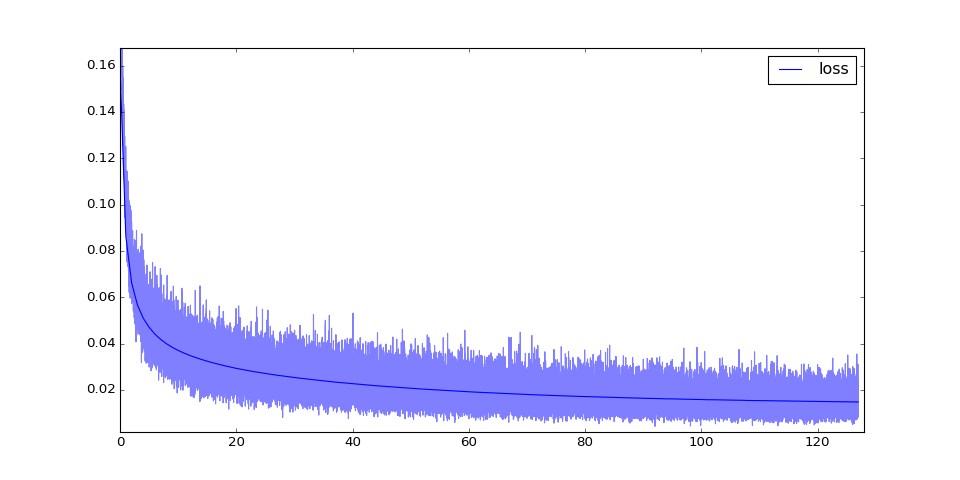

In [9]:
watcher = NNWatcher()

In [10]:
nn.fit(X, y, c_reg = 1.0e-5, learning_rate=1.0, n_epoches=128, batch_size=128, watcher=watcher)

In [11]:
predicted = np.argmax(nn.predict(X_test), axis=1)

In [12]:
np.mean(predicted == y_test)

0.95209999999999995

In [13]:
W1, _, W2, _ = [param.get_value() for param in nn.params]

In [14]:
W1 = W1.reshape(28, 28, -1)

<IPython.core.display.Javascript object>


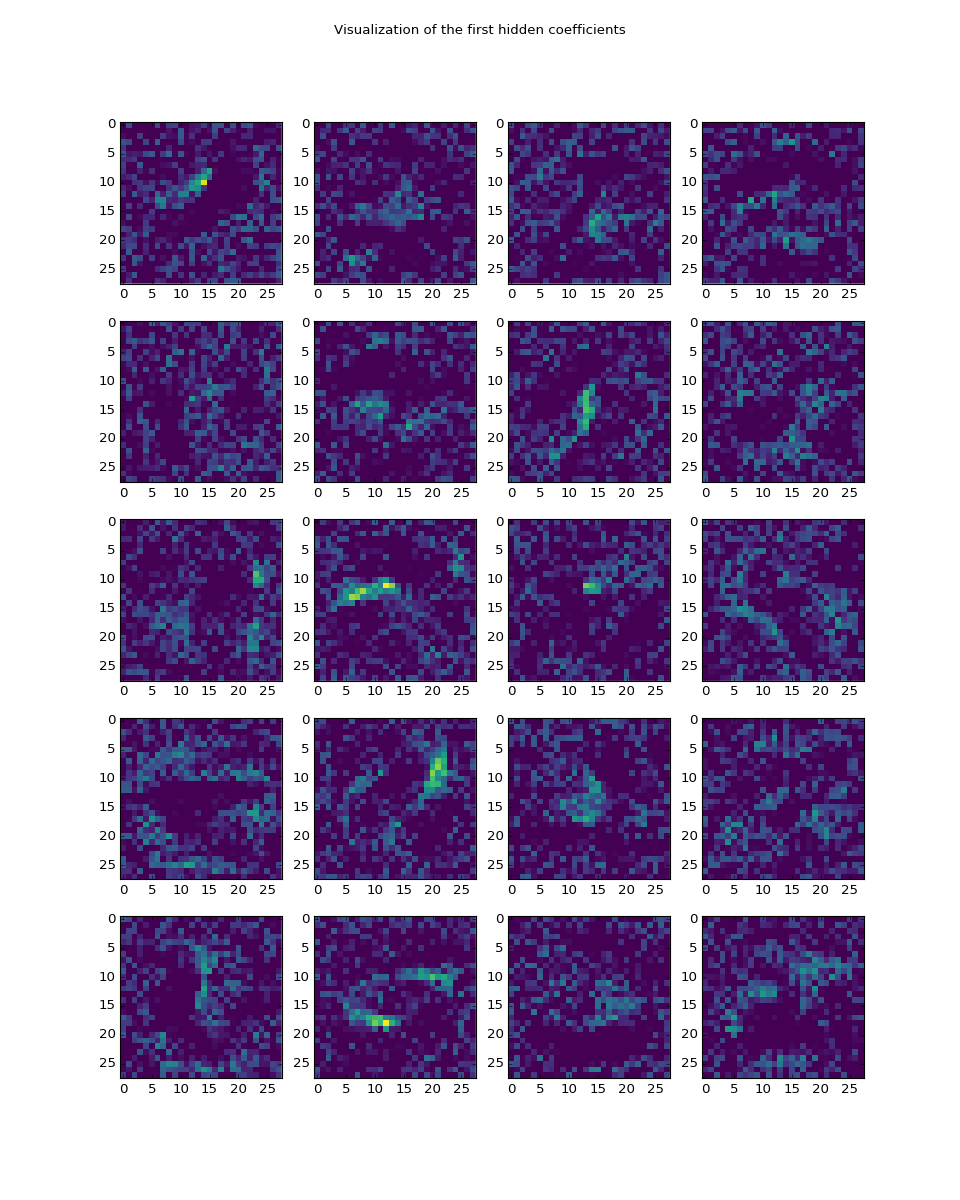

In [25]:
import itertools

nrows = 5
ncols = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 3 , nrows * 3))

for i, j in itertools.product(range(nrows), range(ncols)):
    k = i * ncols + j

    ax[i, j].imshow(
        W1[:, :, k],
        interpolation='None', cmap=plt.cm.viridis, vmin=0.0, vmax=1.0
    )

fig.suptitle('Visualization of the first hidden coefficients')
#fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


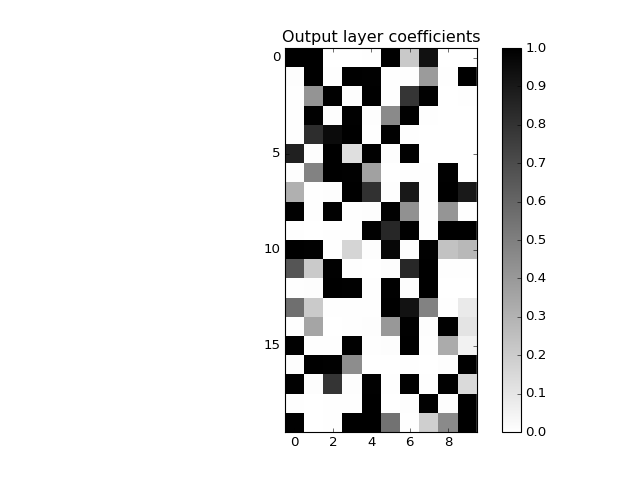

In [23]:
plt.figure()
plt.imshow(W2, interpolation='None', cmap=plt.cm.gray_r, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.title('Output layer coefficients')